# Advanced Use: Simple2D Workflow + Uncertainty Propagation

This version fully refactors the advanced notebook so it is rebuilt on top of the **Simple2D_DIC** procedure:
1. same PlateHole image pair, same ROI mesh generation, and same global/nodal DIC parameters,
2. identical visualization of the displacement and strain fields,
3. uncertainty propagation (image noise → global DIC → nodal DIC → strain computation) added via AD and Jacobian-vector products (JVPs).

Each section therefore revisits steps 1→8 of the simple notebook before chaining the noise model, the differentiable end-to-end function, and the uncertainty statistics.

In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys

import jax
import jax.numpy as jnp
from jax import lax
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh
from D2IC.dic_JaxCore import (
    compute_pixel_state,
    jacobi_nodal_step_spring,
    compute_green_lagrange_strain_nodes_lsq,
)

jax.config.update("jax_enable_x64", True)


def _configure_jax_platform(preferred="gpu", fallback="cpu"):
    """Try GPU first, fallback to CPU if unavailable."""
    try:
        devices = jax.devices(preferred)
    except RuntimeError:
        devices = []
    if devices:
        jax.config.update("jax_platform_name", preferred)
        print(f"JAX backend: {preferred} ({len(devices)} device(s) detected)")
    else:
        jax.config.update("jax_platform_name", fallback)
        print(f"JAX backend: {preferred} unavailable, falling back to {fallback}.")


_configure_jax_platform()


JAX backend: gpu (1 device(s) detected)


W1218 13:39:29.522123   34137 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1218 13:39:29.524354   34060 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## 1) Load the images, ROI, and prepare the folders

im_ref: (1040, 400) float64
im_def: (1040, 400) float64
mask : (1040, 400, 4) uint8


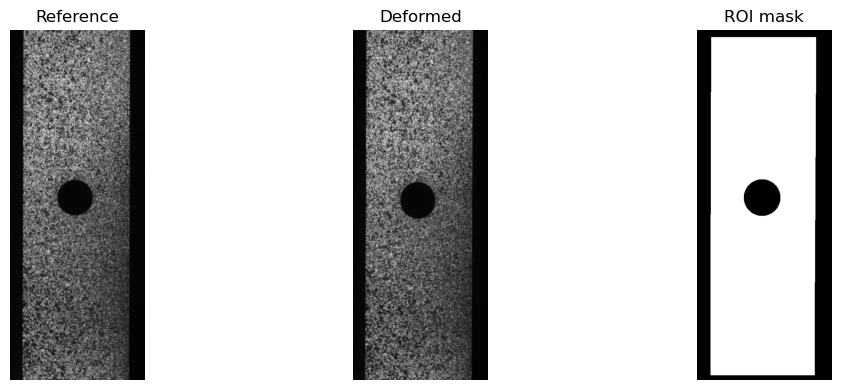

In [2]:

repo_root = None
current = Path.cwd().resolve()
for candidate in (current, *current.parents):
    img_root = candidate / "doc" / "img" / "PlateHole"
    if img_root.exists():
        repo_root = candidate
        break
if repo_root is None:
    raise FileNotFoundError(
        "Could not locate the repository root (doc/img/PlateHole folder missing)."
    )

img_dir = repo_root / "doc" / "img" / "PlateHole"
out_dir = Path("./_outputs")
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "ohtcfrp_00.tif").astype(float)
im_def = imread(img_dir / "ohtcfrp_10.tif").astype(float)
mask = imread(img_dir / "roi.tif")

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()


## 2) Generate the ROI mesh (same as Simple2D)

In [6]:

mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "Simple2D_DIC_roi_mesh.msh"

mesh_path_generated = generate_roi_mesh(mask_path, element_size=20.0, msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)
mesh_path


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.000342413s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 3184 internal 160 closed
Info    : Blossom recombination completed (Wall 0.0191127s, CPU 0.019244s): 1071 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.787633, min Q = 0.507001
Info    : Done meshing 2D (Wall 0.0364746s, CPU 0.034027s)
Info    : 1155 nodes 1243 elements
Info    : Writing '_outputs/Simple2D_DIC_roi_mesh.msh'...
Info    : Done writing '_outputs/Simple2D_DIC_roi_mesh.msh'


PosixPath('_outputs/Simple2D_DIC_roi_mesh.msh')

## 3) Create the DIC object and precompute the pixel data

In [4]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))
dic

Dic(mesh_path=_outputs/Simple2D_DIC_roi_mesh_40px.msh)

## 4) Estimate the initial displacement field (coarse motion)

Retained matches: 14


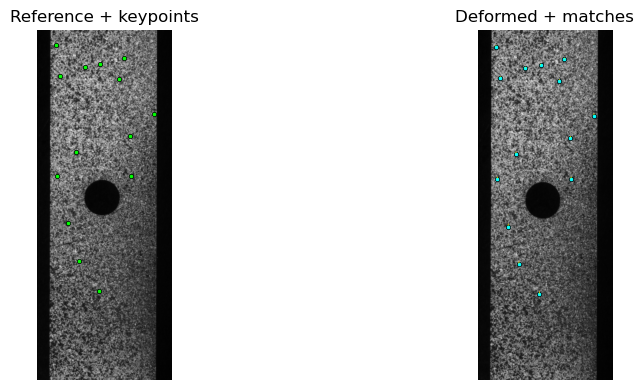

In [7]:

disp_guess, extras = dic.compute_feature_disp_guess_big_motion(
    im_ref,
    im_def,
    n_patches=32,
    patch_win=21,
    patch_search=15,
    refine=True,
    search_dilation=5.0,
)

pts_ref = extras["pts_ref"]
pts_def = extras["pts_def"]
print("Retained matches:", pts_ref.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].scatter(pts_ref[:, 0], pts_ref[:, 1], s=10, c="lime", edgecolors="k", linewidths=0.5)
ax[0].set_title("Reference + keypoints")

ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].scatter(pts_def[:, 0], pts_def[:, 1], s=10, c="cyan", edgecolors="k", linewidths=0.5)
ax[1].quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.003,
)
ax[1].set_title("Deformed + matches")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()


## 5) Global Gauss–Newton DIC (same parameters as Simple2D)

Last solver state: [4.06394749e+00 9.81375717e-04]


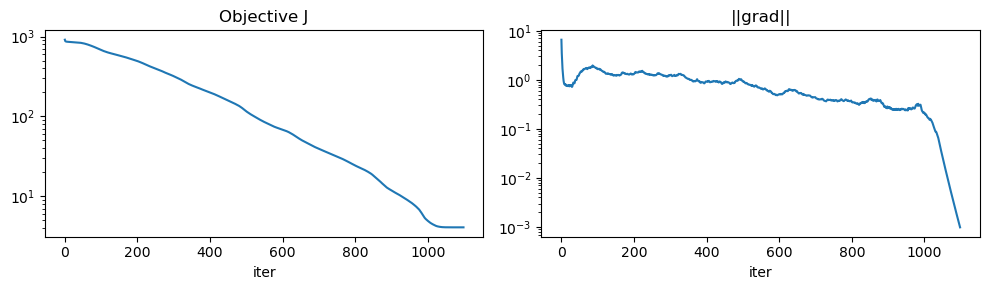

In [11]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=disp_guess,
    max_iter=4000,
    tol=1e-3,
    reg_type="spring",
    alpha_reg=0.1,
    save_history=True,
)

hist = np.asarray(history)
print("Last solver state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective J")
ax[0].set_xlabel("iter")
ax[1].semilogy(hist[:, 1])
ax[1].set_title("||grad||")
ax[1].set_xlabel("iter")
plt.tight_layout()
plt.show()


## 6) Visualize the global displacement

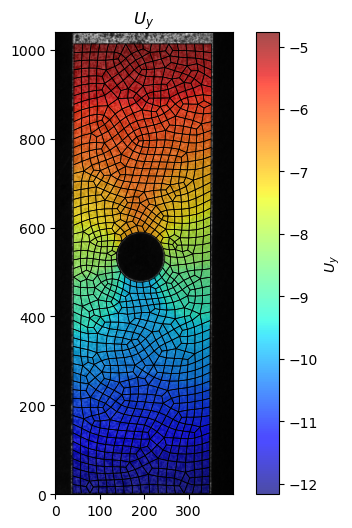

In [12]:

plotter_global = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement),
    dic_object=dic,
)

fig, _ = plotter_global.plot_displacement_component("Uy", image_alpha=0.7)
plt.show()


## 7) Local nodal refinement (same as the simple notebook)

[Nodal-spring_jacobi] sweep 1/10, J=3.8109e+00
[Nodal-spring_jacobi] sweep 2/10, J=4.7246e+00
[Nodal-spring_jacobi] sweep 3/10, J=4.9051e+00
[Nodal-spring_jacobi] sweep 4/10, J=4.9896e+00
[Nodal-spring_jacobi] sweep 5/10, J=5.0267e+00
[Nodal-spring_jacobi] sweep 6/10, J=5.0475e+00
[Nodal-spring_jacobi] sweep 7/10, J=5.0602e+00
[Nodal-spring_jacobi] sweep 8/10, J=5.0685e+00
[Nodal-spring_jacobi] sweep 9/10, J=5.0742e+00
[Nodal-spring_jacobi] sweep 10/10, J=5.0782e+00


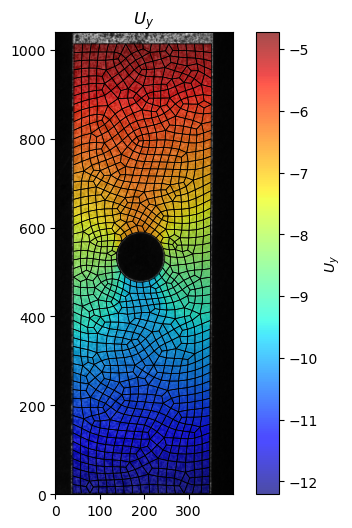

<Figure size 640x480 with 0 Axes>

In [13]:

displacement_refined = dic.run_dic_nodal(
    im_ref,
    im_def,
    disp_init=displacement,
    n_sweeps=10,
    lam=0.1,
    reg_type="spring_jacobi",
    alpha_reg=1.0,
    max_step=0.2,
    omega_local=0.5,
)

plotter_refined = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement_refined),
    dic_object=dic,
)
fig, _ = plotter_refined.plot_displacement_component("Uy", image_alpha=0.7)
plt.savefig(out_dir / "Simple2D_DIC_Ohtcfrp_Uy_field.png", dpi=300)
plt.show()

fig, _ = plotter_refined.plot_displacement_component("Ux", image_alpha=0.7)
plt.savefig(out_dir / "Simple2D_DIC_Ohtcfrp_Ux_field.png", dpi=300)
plt.show()


## 8) Compute the nodal strains

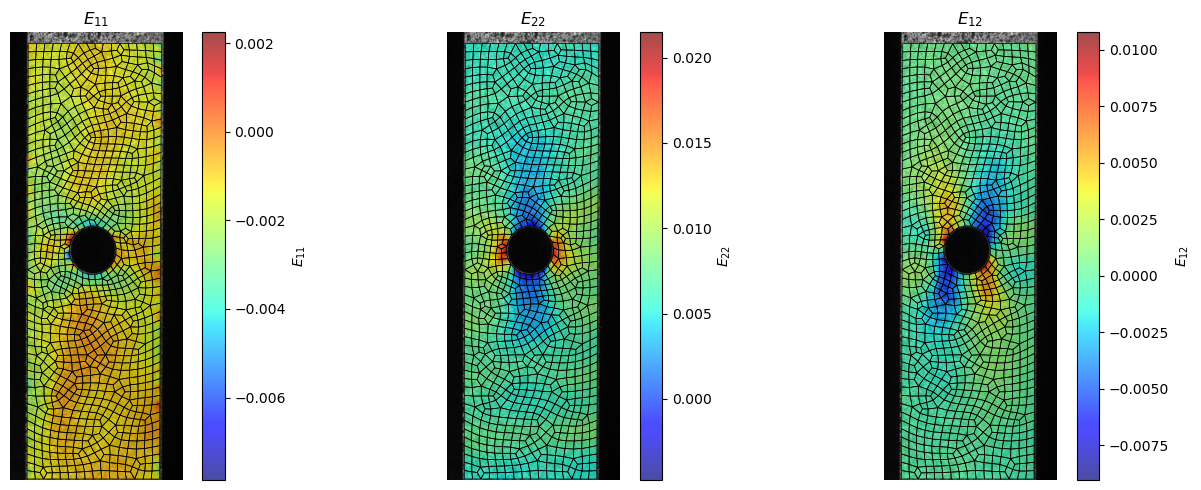

In [14]:

F_all, E_all = dic.compute_green_lagrange_strain_nodes(
    displacement_refined,
    k_ring=2,
    gauge_length=40.0,
)

plotter_strain = DICPlotter(
    background_image=im_def,
    displacement=displacement_refined,
    strain_fields=(F_all, E_all),
    dic_object=dic,
)

component_names = ("Exx", "Eyy", "Exy")
strain_scale = 1e6
strain_unit_label = "µdef"
reference_strain_fields = {
    name: strain_scale * np.asarray(E_all[:, idx_i, idx_j])
    for name, (idx_i, idx_j) in zip(component_names, [(0, 0), (1, 1), (0, 1)])
}


def plot_scalar_field(ax, field_name, cmap="jet", image_alpha=0.7):
    ax.imshow(plotter_strain.background_image, cmap="gray", origin="lower", alpha=1.0)
    field_map = plotter_strain._get_scalar_field_map(field_name)
    masked = np.ma.array(field_map, mask=~np.isfinite(field_map))
    mesh = ax.imshow(masked, cmap=cmap, origin="lower", alpha=image_alpha)
    quad_mesh = plotter_strain._quad_mesh_collection()
    if quad_mesh is not None:
        ax.add_collection(quad_mesh)
    ax.set_aspect("equal")
    ax.set_title(plotter_strain._latex_label(field_name, "strain"))
    ax.set_axis_off()
    return mesh

fields = [("Exx", "Exx"), ("Eyy", "Eyy"), ("Exy", "Exy")]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, (field_name, _) in zip(axes, fields):
    mesh = plot_scalar_field(ax, field_name)
    label = plotter_strain._latex_label(field_name, "strain")
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=label)
plt.tight_layout()
plt.savefig(out_dir / "Simple2D_DIC_Ohtcfrp_Estrain_fields.png", dpi=300)
plt.show()


## 9) Image noise model

In [19]:

sigma_I = 2.0  # std du bruit en niveaux de gris
rng_key = random.PRNGKey(0)

im2_jax = jnp.asarray(im_def)

print(f"Using sigma_I = {sigma_I:.3f} (fraction of 8-bit range: {sigma_I/255:.4f})")


def sample_image_noise(key, sigma=sigma_I):
    """Draw one noise realization matching the shape of I2."""
    return sigma * random.normal(key, shape=im2_jax.shape, dtype=im2_jax.dtype)

rng_key, preview_key = random.split(rng_key)
delta_preview = sample_image_noise(preview_key)
print(
    "Preview noise stats -> mean: {:.3e}, std: {:.3e}".format(
        float(jnp.mean(delta_preview)), float(jnp.std(delta_preview))
    )
)


Using sigma_I = 2.000 (fraction of 8-bit range: 0.0078)
Preview noise stats -> mean: -4.280e-04, std: 2.002e+00


## 10) Differentiable end-to-end function (global DIC + nodal + strains)

In [20]:

binning = float(getattr(dic, "binning", 1.0))
warm_start_disp = jnp.asarray(displacement) / binning

im1_jax = jnp.asarray(im_ref)
im2_jax = jnp.asarray(im_def)
im1_T = jnp.transpose(im1_jax, (1, 0))

pixel_coords_ref = jnp.asarray(dic.pixel_coords_ref)
pixel_nodes = jnp.asarray(dic.pixel_nodes)
pixel_shapeN = jnp.asarray(dic.pixel_shapeN)
node_pixel_index = jnp.asarray(dic.node_pixel_index)
node_N_weight = jnp.asarray(dic.node_N_weight)
node_degree = jnp.asarray(dic.node_degree)
node_neighbor_index = jnp.asarray(dic.node_neighbor_index)
node_neighbor_degree = jnp.asarray(dic.node_neighbor_degree)
node_neighbor_weight = jnp.asarray(dic.node_neighbor_weight)
nodes_coord_binned = jnp.asarray(dic.node_coordinates_binned[:, :2])

cg_max_iter = 400
cg_tol = 1e-3
alpha_reg_global = 0.1

n_sweeps_local = 10
lam_local = 0.1
alpha_reg_local = 1.0
max_step_local = 0.2
omega_local = 0.5
gauge_length = 40.0

@jax.jit
def central_differences(im):
    gx = jnp.zeros_like(im)
    gy = jnp.zeros_like(im)
    gx = gx.at[:, 1:-1].set(0.5 * (im[:, 2:] - im[:, :-2]))
    gy = gy.at[1:-1, :].set(0.5 * (im[2:, :] - im[:-2, :]))
    return gx, gy


def solve_global_dic(im2):
    im2_T = jnp.transpose(im2, (1, 0))
    disp_sol, _, _, _, _ = dic._solve_jit(
        warm_start_disp,
        im1_T,
        im2_T,
        pixel_coords_ref,
        pixel_nodes,
        pixel_shapeN,
        node_neighbor_index,
        node_neighbor_degree,
        node_neighbor_weight,
        alpha_reg_global,
        cg_max_iter,
        cg_tol,
        False,
    )
    return disp_sol * jnp.asarray(binning)


def refine_nodal(im2, disp_global):
    im2 = jnp.asarray(im2)
    im2_T = jnp.transpose(im2, (1, 0))
    gx2, gy2 = central_differences(im2)
    gx2_T = jnp.transpose(gx2, (1, 0))
    gy2_T = jnp.transpose(gy2, (1, 0))

    def sweep(_, disp_curr):
        r, _x_def, gx_def, gy_def = compute_pixel_state(
            disp_curr,
            im1_T,
            im2_T,
            pixel_coords_ref,
            pixel_nodes,
            pixel_shapeN,
            gx2_T,
            gy2_T,
        )
        updated = jacobi_nodal_step_spring(
            disp_curr,
            r,
            gx_def,
            gy_def,
            node_pixel_index,
            node_N_weight,
            node_degree,
            node_neighbor_index,
            node_neighbor_degree,
            node_neighbor_weight,
            lam=lam_local,
            max_step=max_step_local,
            alpha_reg=alpha_reg_local,
            omega=omega_local,
        )
        return updated

    disp_local = disp_global / binning
    disp_local = lax.fori_loop(0, n_sweeps_local, sweep, disp_local)
    return disp_local * binning


def _end_to_end_strain(I2_perturbed):
    """Propagate a perturbed I2 through global DIC, nodal sweeps, and strain post-processing."""
    im2 = jnp.asarray(I2_perturbed)
    disp_global = solve_global_dic(im2)
    disp_refined = refine_nodal(im2, disp_global)

    _F_all, E_all = compute_green_lagrange_strain_nodes_lsq(
        disp_refined,
        nodes_coord_binned,
        node_neighbor_index,
        node_neighbor_degree,
        gauge_length=jnp.asarray(gauge_length),
    )
    return jnp.stack((E_all[:, 0, 0], E_all[:, 1, 1], E_all[:, 0, 1]), axis=0)


end_to_end_strain = jax.jit(_end_to_end_strain)
reference_strain_stack = end_to_end_strain(im2_jax)
reference_strain_from_ad = {
    name: strain_scale * np.asarray(reference_strain_stack[i])
    for i, name in enumerate(component_names)
}


In [21]:

reference_strain_diagnostics = {}
for name in component_names:
    diff = float(np.max(np.abs(reference_strain_from_ad[name] - reference_strain_fields[name])))
    reference_strain_diagnostics[name] = diff
    print(f"{name}: max |AD - reference| = {diff:.3e} [{strain_unit_label}]")


Exx: max |AD - reference| = 7.506e+03 [µdef]
Eyy: max |AD - reference| = 5.853e+03 [µdef]
Exy: max |AD - reference| = 7.560e+03 [µdef]


## 11) First-order propagation (JVP)

In [22]:

rng_key, jvp_key = random.split(rng_key)
delta_I2 = sample_image_noise(jvp_key)
_, delta_E_stack = jax.jvp(end_to_end_strain, (im2_jax,), (delta_I2,))

for i, name in enumerate(component_names):
    delta_component_micro = strain_scale * delta_E_stack[i]
    mean_delta = float(jnp.mean(delta_component_micro))
    std_delta = float(jnp.std(delta_component_micro))
    max_delta = float(jnp.max(jnp.abs(delta_component_micro)))
    print(
        f"{name}: mean(deltaE)={mean_delta:.3e} {strain_unit_label}, "
        f"std={std_delta:.3e} {strain_unit_label}, "
        f"max |deltaE|={max_delta:.3e} {strain_unit_label}"
    )


Exx: mean(deltaE)=-1.225e+01 µdef, std=3.443e+02 µdef, max |deltaE|=2.638e+03 µdef
Eyy: mean(deltaE)=5.450e+00 µdef, std=3.381e+02 µdef, max |deltaE|=2.825e+03 µdef
Exy: mean(deltaE)=7.612e+00 µdef, std=2.572e+02 µdef, max |deltaE|=1.870e+03 µdef


## 12) Monte Carlo estimation of spatial standard deviations

In [23]:

n_mc = 12
mc_keys = random.split(rng_key, n_mc + 1)
rng_key = mc_keys[-1]
mc_keys = mc_keys[:-1]

deltaE_samples = []
for idx, key in enumerate(mc_keys):
    delta_sample = sample_image_noise(key)
    _, delta_E = jax.jvp(end_to_end_strain, (im2_jax,), (delta_sample,))
    deltaE_samples.append(delta_E)
    if (idx + 1) % 6 == 0:
        print(f"Completed {idx + 1}/{n_mc} JVP evaluations")

deltaE_samples = jnp.stack(deltaE_samples, axis=0)
std_strain_stack = jnp.sqrt(jnp.mean(deltaE_samples ** 2, axis=0))
std_strain_fields = {name: strain_scale * np.asarray(std_strain_stack[i]) for i, name in enumerate(component_names)}

for name in component_names:
    print(
        f"{name}: mean std = {np.mean(std_strain_fields[name]):.3e} {strain_unit_label}, "
        f"max std = {np.max(std_strain_fields[name]):.3e} {strain_unit_label}"
    )


Completed 6/12 JVP evaluations
Completed 12/12 JVP evaluations
Exx: mean std = 2.893e+02 µdef, max std = 2.018e+03 µdef
Eyy: mean std = 2.647e+02 µdef, max std = 1.971e+03 µdef
Exy: mean std = 2.049e+02 µdef, max std = 1.352e+03 µdef


## 13) Visualize reference fields and uncertainties

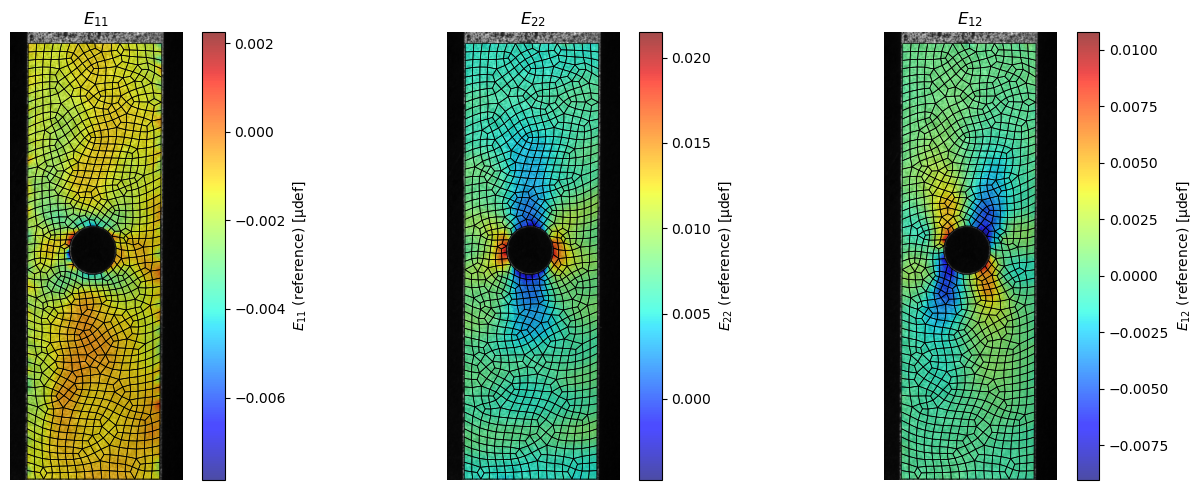

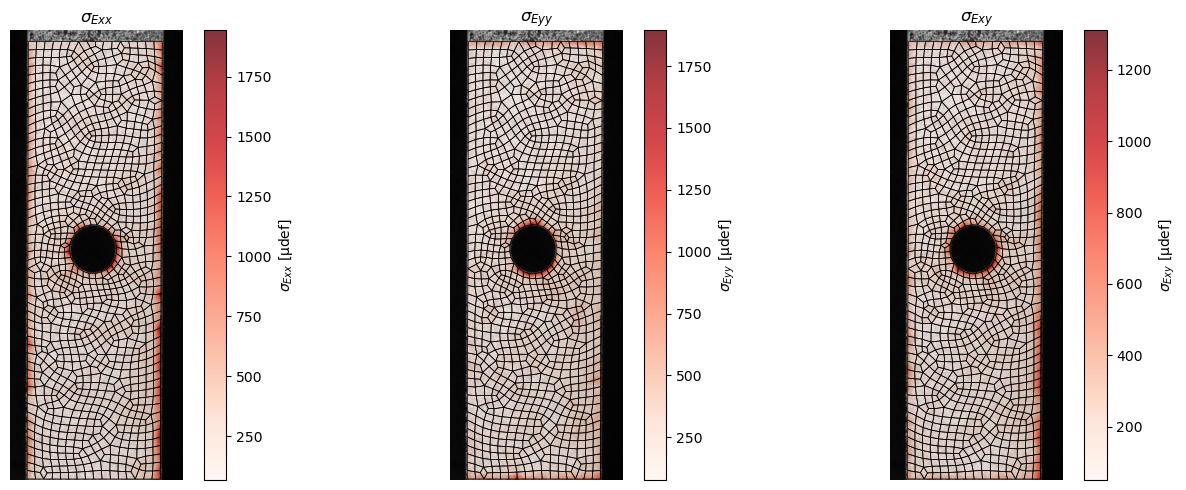

In [24]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    mesh = plot_scalar_field(ax, name)
    title = plotter_strain._latex_label(name, "strain") + " (reference)"
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, name in zip(axes, component_names):
    values = std_strain_fields[name]
    field_map = plotter_strain._interpolate_scalar_field(values)
    ax.imshow(plotter_strain.background_image, cmap="gray", origin="lower", alpha=1.0)
    mesh = ax.imshow(field_map, cmap="Reds", origin="lower", alpha=0.8)
    quad_mesh = plotter_strain._quad_mesh_collection()
    if quad_mesh is not None:
        ax.add_collection(quad_mesh)
    ax.set_aspect("equal")
    ax.set_axis_off()
    title = rf"$\sigma_{{{name}}}$"
    ax.set_title(title)
    fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04, label=f"{title} [{strain_unit_label}]")
plt.tight_layout()
plt.savefig(out_dir / "Advanced_Use_Uncertainty_strain_std.png", dpi=300)
plt.show()


## 14) Texture-based regions with higher/lower confidence

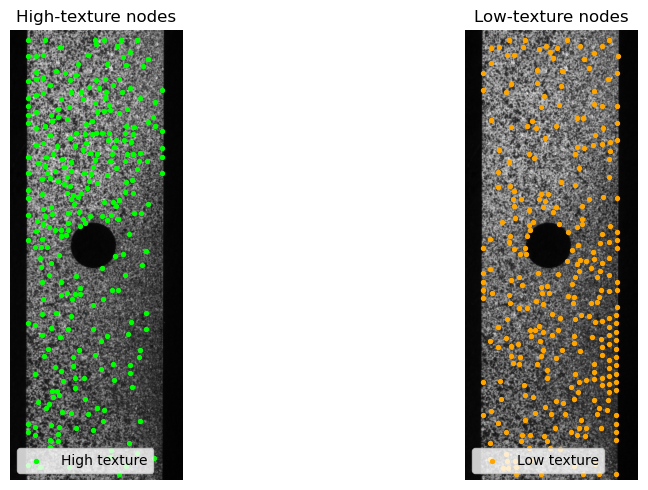

Exx: mean sigma high-texture = 2.469e+02 µdef, mean sigma low-texture = 3.375e+02 µdef
Eyy: mean sigma high-texture = 2.405e+02 µdef, mean sigma low-texture = 2.738e+02 µdef


In [25]:

gradx_ref, grady_ref = central_differences(jnp.asarray(im_ref))
texture_map = np.sqrt(np.asarray(gradx_ref) ** 2 + np.asarray(grady_ref) ** 2)
node_coords = np.asarray(dic.node_coordinates_binned[:, :2])
H, W = texture_map.shape
jj = np.clip(np.round(node_coords[:, 0] - 0.5).astype(int), 0, W - 1)
ii = np.clip(np.round(node_coords[:, 1] - 0.5).astype(int), 0, H - 1)
texture_at_nodes = texture_map[ii, jj]

q25 = np.percentile(texture_at_nodes, 25)
q75 = np.percentile(texture_at_nodes, 75)
mask_low = texture_at_nodes <= q25
mask_high = texture_at_nodes >= q75

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes[0].imshow(im_ref, cmap="gray", origin="lower")
axes[0].scatter(node_coords[mask_high, 0], node_coords[mask_high, 1], s=8, c="lime", label="High texture")
axes[0].set_title("High-texture nodes")
axes[0].legend(loc="lower left")
axes[1].imshow(im_ref, cmap="gray", origin="lower")
axes[1].scatter(node_coords[mask_low, 0], node_coords[mask_low, 1], s=8, c="orange", label="Low texture")
axes[1].set_title("Low-texture nodes")
axes[1].legend(loc="lower left")
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

for name in component_names[:2]:
    high_std = std_strain_fields[name][mask_high]
    low_std = std_strain_fields[name][mask_low]
    print(
        f"{name}: mean sigma high-texture = {np.mean(high_std):.3e} {strain_unit_label}, "
        f"mean sigma low-texture = {np.mean(low_std):.3e} {strain_unit_label}"
    )


## 15) Validation via finite differences

In [26]:

rng_key, val_key = random.split(rng_key)
delta_validation = sample_image_noise(val_key)
_, delta_E_lin = jax.jvp(end_to_end_strain, (im2_jax,), (delta_validation,))

h = 1e-3
finite_diff = (end_to_end_strain(im2_jax + h * delta_validation) - reference_strain_stack) / h

numerator = jnp.linalg.norm(delta_E_lin - finite_diff)
denom = jnp.linalg.norm(finite_diff)
rel_error = float(numerator / (denom + 1e-12))
max_abs = float(jnp.max(jnp.abs(delta_E_lin - finite_diff)))
print(f"Relative error ||JVP - FD|| / ||FD|| = {rel_error:.3e}")
print(f"Max absolute component-wise diff = {strain_scale * max_abs:.3e} {strain_unit_label}")


Relative error ||JVP - FD|| / ||FD|| = 2.685e-05
Max absolute component-wise diff = 1.664e-01 µdef


## 16) Summary
- The differentiable pipeline strictly replays the Simple2D sequence (global DIC, nodal refinement, strain computation) while exposing its derivatives.
- The uncertainty maps highlight that textured zones near strong contrast gradients exhibit the smallest standard deviations.
- The finite-difference validation confirms the quality of the linearization: the JVP matches finite perturbations for this noise level.
- To explore other scenarios (time series, correlated noise, different regularization), simply adjust the parameters in the sections above while keeping the overall structure.